## Data Preparation

In [70]:
import pandas as pd

In [71]:
sales_df = pd.read_csv('raw_data/EXTR_RPSale.csv')
resbldg_df = pd.read_csv('raw_data/EXTR_ResBldg.txt', sep='\t')

## Exploring Data

In [72]:
sales_df.head()
resbldg_df.head()

,Major,Minor,BldgNbr,NbrLivingUnits,Address,BuildingNumber,Fraction,DirectionPrefix,StreetName,StreetType,...,FpMultiStory,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost
0,440,18,1,1,26503 68TH AVE S 98032,26503,,,68TH,AVE,...,0,0,0,1956,0,0,0,0,3,0
1,520,76,1,1,6740 MARS AVE S 98108,6740,,,MARS,AVE,...,1,0,1,1942,0,0,0,0,3,0
2,640,9,1,1,45521 212TH AVE SE 98022,45521,,,212TH,AVE,...,0,0,0,1945,0,0,0,0,5,0
3,660,11,1,1,520 3RD AVE S 98032,520,,,3RD,AVE,...,0,0,0,1928,0,0,0,0,4,0
4,680,24,1,1,27124 78TH AVE S 98032,27124,,,78TH,AVE,...,0,0,0,1901,1964,0,0,0,3,0


In [73]:
sales_df.info()
resbldg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2033420 entries, 0 to 2033419
Data columns (total 24 columns):
ExciseTaxNbr          int64
Major                 object
Minor                 object
DocumentDate          object
SalePrice             int64
RecordingNbr          object
Volume                object
Page                  object
PlatNbr               object
PlatType              object
PlatLot               object
PlatBlock             object
SellerName            object
BuyerName             object
PropertyType          int64
PrincipalUse          int64
SaleInstrument        int64
AFForestLand          object
AFCurrentUseLand      object
AFNonProfitUse        object
AFHistoricProperty    object
SaleReason            int64
PropertyClass         int64
SaleWarning           object
dtypes: int64(7), object(17)
memory usage: 372.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512548 entries, 0 to 512547
Data columns (total 50 columns):
Major                        51254

In [74]:
sales_df.describe().T

,count,mean,std,min,25%,50%,75%,max
ExciseTaxNbr,2033420.0,2.036498e+06,5.652761e+05,456583.0,1577760.75,2048009.5,2516264.25,2998042.0
SalePrice,2033420.0,5.925071e+05,6.009803e+06,-600.0,0.00,150000.0,350000.00,739885000.0
PropertyType,2033420.0,3.171057e+00,3.932915e+00,0.0,3.00,3.0,3.00,99.0
PrincipalUse,2033420.0,4.607211e+00,2.617056e+00,0.0,2.00,6.0,6.00,11.0
SaleInstrument,2033420.0,7.348003e+00,6.612247e+00,0.0,3.00,3.0,15.00,28.0
SaleReason,2033420.0,5.401358e+00,6.235909e+00,0.0,1.00,1.0,10.00,19.0
PropertyClass,2033420.0,6.509844e+00,2.483860e+00,0.0,3.00,8.0,8.00,9.0


In [79]:
sales_df.duplicated().sum() #0 duplicated rows
resbldg_df.duplicated().sum()    #0 duplicated rows

0

In [76]:
sales_df.isna().sum()    #no NAs
resbldg_df.isna().sum()     #has NAs

Major                            0
Minor                            0
BldgNbr                          0
NbrLivingUnits                   0
Address                          0
BuildingNumber                   0
Fraction                         0
DirectionPrefix                564
StreetName                       0
StreetType                       0
DirectionSuffix                564
ZipCode                      44096
Stories                          0
BldgGrade                        0
BldgGradeVar                     0
SqFt1stFloor                     0
SqFtHalfFloor                    0
SqFt2ndFloor                     0
SqFtUpperFloor                   0
SqFtUnfinFull                    0
SqFtUnfinHalf                    0
SqFtTotLiving                    0
SqFtTotBasement                  0
SqFtFinBasement                  0
FinBasementGrade                 0
SqFtGarageBasement               0
SqFtGarageAttached               0
DaylightBasement                 0
SqFtOpenPorch       

In [80]:
sales_df1 = sales_df.loc[:, (sales_df != 0).any(axis=0)]   #No rows with all zeros
print(sales_df.shape)
print(sales_df1.shape)

(2033420, 24)
(2033420, 24)


In [81]:
resbldg_df1 = resbldg_df.loc[:, (resbldg_df != 0).any(axis=0)]   #No rows with all zeros
print(resbldg_df.shape)
print(resbldg_df1.shape)

(512548, 50)
(512548, 50)


In [82]:
resbldg_df.columns    #space in column headers

Index(['Major ', 'Minor', 'BldgNbr', 'NbrLivingUnits', 'Address',
       'BuildingNumber', 'Fraction', 'DirectionPrefix',
       'StreetName               ', 'StreetType', 'DirectionSuffix', 'ZipCode',
       'Stories   ', 'BldgGrade', 'BldgGradeVar', 'SqFt1stFloor',
       'SqFtHalfFloor', 'SqFt2ndFloor', 'SqFtUpperFloor', 'SqFtUnfinFull',
       'SqFtUnfinHalf', 'SqFtTotLiving', 'SqFtTotBasement', 'SqFtFinBasement',
       'FinBasementGrade', 'SqFtGarageBasement', 'SqFtGarageAttached',
       'DaylightBasement', 'SqFtOpenPorch', 'SqFtEnclosedPorch', 'SqFtDeck  ',
       'HeatSystem', 'HeatSource', 'BrickStone', 'ViewUtilization', 'Bedrooms',
       'BathHalfCount', 'Bath3qtrCount', 'BathFullCount', 'FpSingleStory',
       'FpMultiStory', 'FpFreestanding', 'FpAdditional', 'YrBuilt',
       'YrRenovated', 'PcntComplete', 'Obsolescence', 'PcntNetCondition',
       'Condition', 'AddnlCost'],
      dtype='object')

In [83]:
resbldg_df2 = resbldg_df.rename(columns={'Major ': 'Major', 'SqFtDeck  ': 'SqFtDeck'})   #renaming column header

## Business Understanding: 
### Build a model to predict king county house sale prices

In [84]:
#choosing initial features
sales_df2 = sales_df1[['Major', 'Minor', 'SalePrice']]     
resbldg_df3 = resbldg_df2[['Major', 'Minor', 'SqFtTotLiving', 'Bedrooms', 'SqFtGarageAttached',   
                   'Condition', 'SqFtDeck','BathFullCount', 'ZipCode','HeatSystem', 'YrBuilt']] 

resbldg_df3.head()

,Major,Minor,SqFtTotLiving,Bedrooms,SqFtGarageAttached,Condition,SqFtDeck,BathFullCount,ZipCode,HeatSystem,YrBuilt
0,440,18,1430,3,0,3,130,1,98032,5,1956
1,520,76,2070,3,0,3,0,2,98108,5,1942
2,640,9,850,2,0,5,0,1,98022,4,1945
3,660,11,840,2,0,4,0,1,98032,5,1928
4,680,24,1390,3,0,3,60,1,98032,4,1901


In [85]:
sales_df2['Major'] = pd.to_numeric(sales_df2['Major'], errors='coerce')    #objects into float
sales_df2['Minor'] = pd.to_numeric(sales_df2['Minor'], errors='coerce')
resbldg_df3['Major'] = pd.to_numeric(resbldg_df3['Major'], errors='coerce')

sales_data = pd.merge(sales_df2, resbldg_df3, on=['Major', 'Minor'])       #merge datasets
sales_data.head()

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

,Major,Minor,SalePrice,SqFtTotLiving,Bedrooms,SqFtGarageAttached,Condition,SqFtDeck,BathFullCount,ZipCode,HeatSystem,YrBuilt
0,138860.0,110.0,245000,1490,3,500,3,0,2,98002,5,1989
1,138860.0,110.0,109300,1490,3,500,3,0,2,98002,5,1989
2,138860.0,110.0,14684,1490,3,500,3,0,2,98002,5,1989
3,138860.0,110.0,0,1490,3,500,3,0,2,98002,5,1989
4,423943.0,50.0,0,960,3,240,4,0,1,98092,4,1969


In [63]:
#Do a histogram to see the sale price distribution. 
#For initial visualization, droppping the top and lowest 10% of sale prices 


import numpy as np        
lowest_10percent = np.percentile(sales_data['SalePrice'], 10)
highest_90percent = np.percentile(sales_data['SalePrice'], 90)

sales_data1 = sales_data[sales_data['SalePrice'] > lowest_10percent]
sales_data2 = sales_data1[sales_data1['SalePrice'] < highest_90percent] 

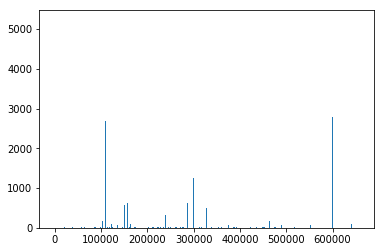

In [64]:
import matplotlib.pyplot as plt    
%matplotlib inline

plt.hist(sales_data2['SalePrice'], bins=30000)
plt.show()

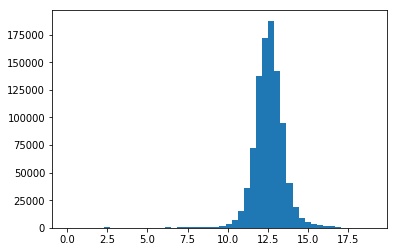

In [65]:
#Histogram above shows that sale prices are not normally distributed.
# log transforming and regenerating histogram on all SalePrices. 
#Histogram shows log transformed prices are normally distributed.
fig, ax = plt.subplots()
ax.hist(np.log(sales_data[sales_data['SalePrice']> 0]['SalePrice']), bins=50);

## Feature Engineering

In [86]:
# Handling the null values
nulls = pd.DataFrame(sales_data.isnull().sum().sort_values(ascending=False))    
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
print(nulls)

                    Null Count
Feature                       
ZipCode                 118382
YrBuilt                      0
HeatSystem                   0
BathFullCount                0
SqFtDeck                     0
Condition                    0
SqFtGarageAttached           0
Bedrooms                     0
SqFtTotLiving                0
SalePrice                    0
Minor                        0
Major                        0


In [87]:
#remove nulls in ZipCode
sales_data = sales_data.dropna(subset = ['ZipCode'])                     
nulls1 = pd.DataFrame(sales_data1.isnull().sum().sort_values(ascending=False))
print(nulls1)

sales_data1.shape                        

                        0
ZipCode             83817
YrBuilt                 0
HeatSystem              0
BathFullCount           0
SqFtDeck                0
Condition               0
SqFtGarageAttached      0
Bedrooms                0
SqFtTotLiving           0
SalePrice               0
Minor                   0
Major                   0


(959055, 12)

In [88]:
#Keep only the positive values for sale price
sales_data = sales_data[sales_data['SalePrice'] > 0]
sales_data['SalePrice'].min()
sales_data.shape

(875238, 12)

In [89]:
# Adding LogSalePrice values as a new column to build the model on log sale prices as our target   
# instead of raw sale prices.
sales_data['LogSalePrice']=np.log(sales_data['SalePrice'])
sales_data.head().T

,0,1,2,6,7
Major,138860,138860,138860,423943,423943
Minor,110,110,110,50,50
SalePrice,245000,109300,14684,96000,127500
SqFtTotLiving,1490,1490,1490,960,960
Bedrooms,3,3,3,3,3
SqFtGarageAttached,500,500,500,240,240
Condition,3,3,3,4,4
SqFtDeck,0,0,0,0,0
BathFullCount,2,2,2,1,1
ZipCode,98002,98002,98002,98092,98092


In [90]:
# keeping the target values above mean minus two standard deviation 
# And below mean plus two standard deviation
#This includes 95% of our target values since logSalePrice is normally distributed. 
print(sales_data['LogSalePrice'].mean())
print(sales_data['LogSalePrice'].std())

mean_minus_twostdv = sales_data['LogSalePrice'].mean() - sales_data['LogSalePrice'].std()*2
mean_plus_twostdv = sales_data['LogSalePrice'].mean() + sales_data['LogSalePrice'].std()*2
print(mean_minus_twostdv)
print(mean_plus_twostdv)

12.520955934374548
0.9381028190239706
10.644750296326606
14.39716157242249


In [91]:
sales_data = sales_data[(sales_data['LogSalePrice'] < mean_plus_twostdv) & 
                         (mean_minus_twostdv < sales_data['LogSalePrice'])]
sales_data.head()
sales_data['LogSalePrice'].describe()

count    840570.000000
mean         12.529701
std           0.707699
min          10.644901
25%          12.040313
50%          12.535376
75%          13.008345
max          14.396608
Name: LogSalePrice, dtype: float64

In [92]:
#keep only the first 5 digits of ZipCode.
def is_integer(x):
   try:
       _ = int(x)
   except ValueError:
       return False
   return True

stringed_zips = sales_data.loc[sales_data['ZipCode'].apply(is_integer) == False, 'ZipCode']
stringed_zips.head()

15064    98033-4917
15065    98033-4917
15066    98033-4917
15067    98033-4917
15068    98033-4917
Name: ZipCode, dtype: object

In [93]:
def zipcode_short(x):
    return str(x)[:5]

sales_data['New_zip'] = sales_data['ZipCode'].map(zipcode_short)
sales_data.head().T
sales_data.shape

(840570, 14)

In [94]:
#remove "WA", space, and "A","B" as ZipCodes
sales_data.drop(sales_data[ sales_data['New_zip'] == "WA" ].index , inplace=True)
sales_data.drop(sales_data[ sales_data['New_zip'] == " " ].index , inplace=True)
sales_data.drop(sales_data[ sales_data['New_zip'] == "B" ].index , inplace=True)
sales_data.drop(sales_data[ sales_data['New_zip'] == "A" ].index , inplace=True)

stringed_zips = sales_data.loc[sales_data['New_zip'].apply(is_integer) == False, 'New_zip']
stringed_zips

Series([], Name: New_zip, dtype: object)

In [95]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import seaborn as sns

In [96]:
#Initial correlation top 5.
numeric_feature = sales_data.select_dtypes(include=[np.number])
corr = numeric_feature.corr()

print(abs(corr['LogSalePrice']).sort_values(ascending=False))

LogSalePrice          1.000000
SalePrice             0.904433
SqFtTotLiving         0.413686
BathFullCount         0.249989
Bedrooms              0.214961
SqFtGarageAttached    0.169400
HeatSystem            0.147714
YrBuilt               0.140826
SqFtDeck              0.137115
Condition             0.022986
Major                 0.015677
Minor                 0.010830
Name: LogSalePrice, dtype: float64


In [97]:
#concatenate Major and Minor into PIN
sales_data['Major'] = sales_data.Major.astype(int)
sales_data['Minor'] = sales_data.Minor.astype(int)

In [98]:
sales_data['Pin'] = sales_data.Major.astype(str) + sales_data.Minor.astype(str)
sales_data.shape

(840559, 15)

In [99]:
#Drop duplicated rows
sales_data = sales_data.drop_duplicates()
sales_data.shape

(828682, 15)

In [100]:
#Choose the top correlated features
sales_data.columns
sales_data = sales_data[['LogSalePrice', 'SqFtTotLiving', 'Bedrooms', 'SqFtGarageAttached', 'SqFtDeck', 
                          'BathFullCount', 'YrBuilt', 'New_zip', 'Pin']].copy()
sales_data.head()

,LogSalePrice,SqFtTotLiving,Bedrooms,SqFtGarageAttached,SqFtDeck,BathFullCount,YrBuilt,New_zip,Pin
0,12.409013,1490,3,500,0,2,1989,98002,138860110
1,11.601852,1490,3,500,0,2,1989,98002,138860110
6,11.472103,960,3,240,0,1,1969,98092,42394350
7,11.755872,960,3,240,0,1,1969,98092,42394350
11,13.048717,1780,4,520,0,1,1957,98008,403700715


## Visualization

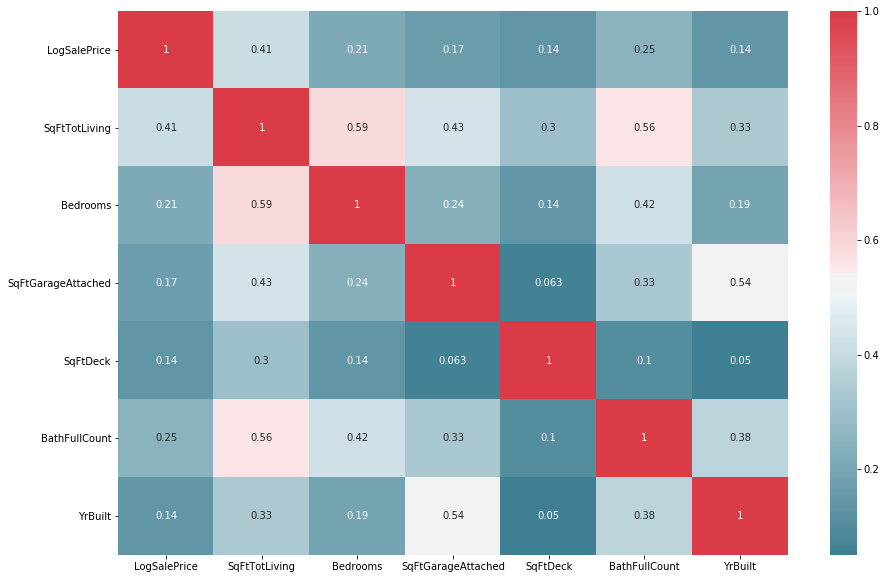

In [101]:
#Heatmap of features
def correlation_heatmap(df1):
   _, ax = plt.subplots(figsize = (15, 10))
   colormap= sns.diverging_palette(220, 10, as_cmap = True)
   sns.heatmap(df1.corr(), annot=True, cmap = colormap)

correlation_heatmap(sales_data)

(array([57.,  6.,  8., 17., 14.,  6.,  6.,  6.,  3.,  2.]),
 array([1.00000e+00, 2.62740e+03, 5.25380e+03, 7.88020e+03, 1.05066e+04,
        1.31330e+04, 1.57594e+04, 1.83858e+04, 2.10122e+04, 2.36386e+04,
        2.62650e+04]),
 <a list of 10 Patch objects>)

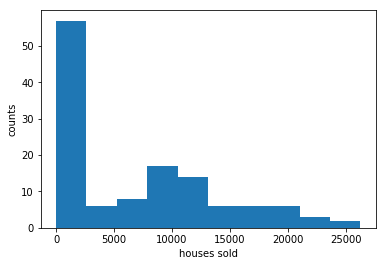

In [102]:
#See the distribution of house sales based on ZipCode
plt.xlabel('houses sold')
plt.ylabel('counts')

plt.hist(sales_data['New_zip'].value_counts())

In [103]:
zipcode_counts = sales_data['New_zip'].value_counts().to_dict()

In [104]:
sales_data['Zip_count'] = sales_data['New_zip'].apply(lambda z: zipcode_counts[z])

In [105]:
#Keep the ZipCodes with over 15000 house sales
sales_data_over_15k = sales_data[sales_data['Zip_count'] > 15000]
sales_data_over_15k.head()

,LogSalePrice,SqFtTotLiving,Bedrooms,SqFtGarageAttached,SqFtDeck,BathFullCount,YrBuilt,New_zip,Pin,Zip_count
16,11.849040,2050,4,0,260,1,1967,98058,98400380,19750
17,12.993393,2050,4,0,260,1,1967,98058,98400380,19750
19,12.721886,2210,3,650,500,2,1994,98038,3303951610,21369
20,12.820988,2210,3,650,500,2,1994,98038,3303951610,21369
21,12.170186,2210,3,650,500,2,1994,98038,3303951610,21369


In [106]:
Zip_by_price = sales_data_over_15k.groupby('New_zip')['LogSalePrice'].mean().sort_values()
Zip_by_price

New_zip
98023    12.199940
98001    12.209329
98031    12.276511
98118    12.295413
98042    12.316935
98133    12.359890
98058    12.366849
98155    12.375569
98056    12.461578
98038    12.488983
98034    12.535419
98117    12.567963
98059    12.606677
98103    12.630655
98115    12.640037
98052    12.723718
98033    12.805536
98074    12.849898
98006    12.873801
Name: LogSalePrice, dtype: float64

In [107]:
zcodes = list(Zip_by_price.index)
for zc in zcodes:
    sales_data_over_15k[zc] = (sales_data_over_15k['New_zip'] == zc).astype(int)

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [108]:
sales_data_over_15k.head()

,LogSalePrice,SqFtTotLiving,Bedrooms,SqFtGarageAttached,SqFtDeck,BathFullCount,YrBuilt,New_zip,Pin,Zip_count,...,98038,98034,98117,98059,98103,98115,98052,98033,98074,98006
16,11.849040,2050,4,0,260,1,1967,98058,98400380,19750,...,0,0,0,0,0,0,0,0,0,0
17,12.993393,2050,4,0,260,1,1967,98058,98400380,19750,...,0,0,0,0,0,0,0,0,0,0
19,12.721886,2210,3,650,500,2,1994,98038,3303951610,21369,...,1,0,0,0,0,0,0,0,0,0
20,12.820988,2210,3,650,500,2,1994,98038,3303951610,21369,...,1,0,0,0,0,0,0,0,0,0
21,12.170186,2210,3,650,500,2,1994,98038,3303951610,21369,...,1,0,0,0,0,0,0,0,0,0


In [109]:
#Initial correlation of zipcodes with logsalePrice.
numeric_feature = sales_data_over_15k.select_dtypes(include=[np.number])
corr = numeric_feature.corr()

print(abs(corr['LogSalePrice']).sort_values(ascending = False))

LogSalePrice          1.000000
SqFtTotLiving         0.388788
BathFullCount         0.246095
Bedrooms              0.207515
SqFtGarageAttached    0.161473
YrBuilt               0.153678
98006                 0.132266
98023                 0.118022
SqFtDeck              0.113968
98074                 0.112933
98033                 0.097534
98001                 0.093402
98052                 0.080995
98042                 0.076237
98031                 0.070777
98118                 0.070473
98115                 0.052749
98058                 0.047876
98133                 0.046960
98103                 0.044952
98155                 0.040634
Zip_count             0.036575
98059                 0.032812
98117                 0.022996
98056                 0.012574
98034                 0.011968
98038                 0.004999
Name: LogSalePrice, dtype: float64


In [124]:
#Build a multiple linear regression with the top 7 features
Y = sales_data_over_15k['LogSalePrice']
important_feat = [ele for ele in sales_data_over_15k.columns if ele in {'SqFtTotLiving', 'BathFullCount', 'Bedrooms', 'SqFtGarageAttached','SqFtDeck','YrBuilt','98006'}] 
X = sales_data_over_15k[important_feat]


In [125]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import linear_model

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 1000, test_size=.3)

lr = linear_model.LinearRegression()

In [126]:
model = lr.fit(X_train, y_train)
print("R^2 is:", model.score(X_test, y_test))

R^2 is: 0.15577869013095447


In [113]:
metrics.mean_absolute_error(y_test, lr.predict(X_test))

0.4921284621094131

In [114]:
prediction = model.predict(X_test)
print("RSSE is:", (mean_squared_error(y_test, prediction)**.5))

RSSE is: 0.6227371034500055


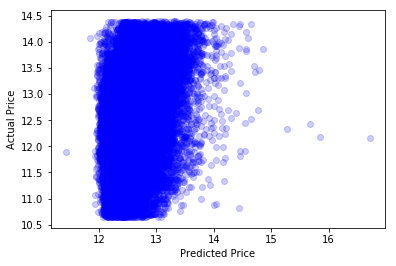

In [115]:
actual_values = y_test
plt.scatter(prediction, actual_values, alpha=.2, color='b') 
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.show()

In [145]:
#Build a multiple linear regression with each of the top 7 features
featurelist = ['SqFtTotLiving', 'BathFullCount', 'Bedrooms', 'SqFtGarageAttached','SqFtDeck','YrBuilt','98006'] 
def eachfeature(featurelist):
    X = None
    for feature in featurelist:
        X_train, X_test, y_train, y_test = train_test_split(np.array(sales_data_over_15k[feature]).reshape(-1,1), Y, random_state = 1000, test_size=.3)
        lr = linear_model.LinearRegression()
        model = lr.fit(X_train, y_train)
        print(f"R^2 for {feature} is:{model.score(X_test, y_test)}") 
        print(f"mean_absolute_error for {feature} is: {metrics.mean_absolute_error(y_test, lr.predict(X_test))}")
        
        

In [146]:
eachfeature(featurelist)

R^2 for SqFtTotLiving is:0.15050223380323324
mean_absolute_error for SqFtTotLiving is: 0.4940192106761743
R^2 for BathFullCount is:0.05875530684431396
mean_absolute_error for BathFullCount is: 0.5246076767507756
R^2 for Bedrooms is:0.04284622089692025
mean_absolute_error for Bedrooms is: 0.5301587008866037
R^2 for SqFtGarageAttached is:0.02543090473911924
mean_absolute_error for SqFtGarageAttached is: 0.5354292324795797
R^2 for SqFtDeck is:0.013637627013064701
mean_absolute_error for SqFtDeck is: 0.5397364712800606
R^2 for YrBuilt is:0.02335896244856439
mean_absolute_error for YrBuilt is: 0.5364148646042672
R^2 for 98006 is:0.01723059195330523
mean_absolute_error for 98006 is: 0.538528834479249
